In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from tqdm import tqdm
import cv2

In [5]:
def wrap_int64(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def wrap_bytes(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def wrap_float(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

In [10]:
shard_path = '../../../../data/commaai/training_files/unfiltered_smaller_images/'
shard_files = glob.glob(os.path.join(shard_path, "*.tfrecords")) 

In [15]:
(32+59+84+77+122)/5

74.8

In [55]:
def imgs_input_fn(filenames, perform_shuffle = False, repeat_count = 1, batch_size = 10000): 
    
    # reads in single training example and returns it in a format that the estimator can
    # use
    def _parse_function(proto):
        # define your tfrecord again. Remember that you saved your image as a string.
        keys_to_features = {'image': tf.io.FixedLenFeature([], tf.string),
                            'label': tf.io.FixedLenFeature([], tf.float32),
                            'rows': tf.io.FixedLenFeature([], tf.int64),
                            'cols': tf.io.FixedLenFeature([], tf.int64),
                            'depth': tf.io.FixedLenFeature([], tf.int64),
                            'tr_label': tf.io.FixedLenFeature([], tf.float32)
                           }

        # Load one example
        parsed_example = tf.io.parse_single_example(proto, keys_to_features)
        # fourth channel does not contain anything
        image_shape = tf.stack([66, 200, 4])
        image_raw = parsed_example['image']

        label = tf.cast(parsed_example['label'], tf.float32)
        tr_label = tf.cast(parsed_example['tr_label'], tf.float32)
        image = tf.io.decode_raw(image_raw, tf.uint8)
        image = tf.cast(image, tf.float32)

        image = tf.reshape(image, image_shape)
        
        return {'image':image}, tr_label, label
    
    dataset = tf.data.TFRecordDataset(filenames = filenames)
    dataset = dataset.map(_parse_function)
    if perform_shuffle:
        # Randomizes input using a window of 256 elements (read into memory)
        dataset = dataset.shuffle(buffer_size=256)
    dataset = dataset.repeat(repeat_count)  # Repeats dataset this # times
    dataset = dataset.batch(batch_size)  # Batch size to use
    iterator = tf.compat.v1.data.make_one_shot_iterator(dataset)
    batch_features, batch_labels, batch_y = iterator.get_next()
    
    return batch_features, batch_labels, batch_y

In [57]:
out_path_base = '../../../data/commaai/training_files/unfiltered_smaller_images_y/'

i = 0

for shard in tqdm(shard_files):
    
    # get resized and cropped images and labels
    batch_features, batch_labels, batch_y = imgs_input_fn(shard)
    
    batch_features = np.array(batch_features['image'])
    batch_labels = np.array(batch_labels)
    batch_y = np.array(batch_y)
    
    # shard name
    out_path_shard = out_path_shard = str(out_path_base + str(i) + '.tfrecords')
    
    # save in new tfrecords file
    with tf.io.TFRecordWriter(out_path_shard) as writer:
        
        for j in range(0, batch_features.shape[0]):
            img = batch_features[j, :, :, :].astype('int64')
            tr_label = batch_labels[j]
            label = batch_y[j]
            
            img_bytes = img.tobytes()[0::8]
            # save image and label in dictionary
            data = \
                    {
                        'image': wrap_bytes(img_bytes),
                        'tr_label': wrap_float(tr_label)
                    }
            feature = tf.train.Features(feature=data)

            # Wrap again as a TensorFlow Example.
            example = tf.train.Example(features=feature)

            serialized = example.SerializeToString()
            
            # Write the serialized data to the TFRecords file.
            writer.write(serialized)
            
            with open(str(out_path_base + 'yaws.csv'), 'a') as csvfile:
                                csvfile.write("%s\n" % label)    
    i += 1

100%|██████████| 2226/2226 [2:18:33<00:00,  3.73s/it]  


In [33]:
img = batch_features[0, :, :, :].astype('int64')

In [34]:
img

array([[[20, 29, 31],
        [20, 27, 31],
        [23, 32, 34],
        ...,
        [18, 24, 27],
        [18, 24, 27],
        [19, 25, 28]],

       [[18, 27, 29],
        [23, 31, 36],
        [24, 32, 37],
        ...,
        [18, 24, 27],
        [17, 23, 26],
        [17, 23, 26]],

       [[20, 29, 31],
        [25, 34, 34],
        [26, 35, 35],
        ...,
        [19, 25, 28],
        [18, 24, 27],
        [17, 23, 26]],

       ...,

       [[48, 54, 55],
        [49, 55, 56],
        [49, 55, 56],
        ...,
        [15, 23, 31],
        [16, 24, 33],
        [16, 24, 33]],

       [[54, 63, 65],
        [55, 64, 66],
        [54, 63, 65],
        ...,
        [16, 25, 34],
        [15, 25, 33],
        [15, 23, 32]],

       [[53, 62, 64],
        [53, 62, 64],
        [53, 62, 64],
        ...,
        [18, 26, 35],
        [17, 25, 34],
        [17, 25, 34]]])

In [ ]:
len((img[0,0,0]).tobytes())

In [ ]:
print((img[0,0,0]).tobytes())

In [ ]:
plt.imshow(batch_features[0].astype(int))

In [ ]:
img = batch_features[j, :, :, :].reshape(66,200,3).astype(int)

In [ ]:
batch_features[0, :, :, :].shape

In [ ]:
plt.imshow(img)

In [51]:
def imgs_input_fn_2(filenames, perform_shuffle = False, repeat_count = 1, batch_size = 10000): 
    
    # reads in single training example and returns it in a format that the estimator can
    # use
    def _parse_function(proto):
        # define your tfrecord again. Remember that you saved your image as a string.
        keys_to_features = {'image': tf.io.FixedLenFeature([], tf.string),
                            'tr_label': tf.io.FixedLenFeature([], tf.float32)
                           }

        # Load one example
        parsed_example = tf.io.parse_single_example(proto, keys_to_features)
        # fourth channel does not contain anything
        image_shape = tf.stack([66, 200, 3])
        image_raw = parsed_example['image']

        tr_label = tf.cast(parsed_example['tr_label'], tf.float32)
        image = tf.io.decode_raw(image_raw, tf.uint8)
        image = tf.cast(image, tf.float32)

        image = tf.reshape(image, image_shape)
        image = image
        
        return {'image':image}, tr_label
    
    dataset = tf.data.TFRecordDataset(filenames = filenames)
    dataset = dataset.map(_parse_function)
    if perform_shuffle:
        # Randomizes input using a window of 256 elements (read into memory)
        dataset = dataset.shuffle(buffer_size=256)
    dataset = dataset.repeat(repeat_count)  # Repeats dataset this # times
    dataset = dataset.batch(batch_size)  # Batch size to use
    iterator = tf.compat.v1.data.make_one_shot_iterator(dataset)
    batch_features, batch_labels= iterator.get_next()
    
    return batch_features, batch_labels

In [52]:
imgs, tr_ang = imgs_input_fn_2('../../../data/commaai/training_files/unfiltered_smaller_images/0.tfrecords')

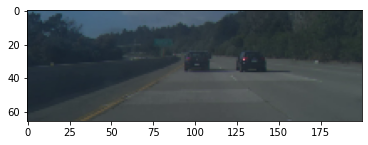

In [53]:
plt.imshow(imgs['image'][0]/255)